# Creating and Evaluating our Model 

# Import necessary libraries

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import MaxPooling1D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.callbacks import Callback

# Loading and Combining data

We load the **GermanFakeNC** dataset with threshold 0.5 and the balanced **news** dataset and then we combine it in a new dataset named df_combined and we shuffle the data.

In [62]:
#If you didn't run the preprocess codes you can used the already preprocessed 
#data by changing the first and the third line of code with the following.
#df_news = pd.read_csv('..\\..\\Datasets\\Preprocessed\\df_preprocessed_news', index_col=0)
#df_germanFakeNC = pd.read_csv('..\\..\\Datasets\\Preprocessed\\df_preprocessed_GermanFakeNC', index_col=0)

df_news = pd.read_csv('..\\..\\Datasets\\news\\df_preprocessed_news', index_col=0)
df_news = df_news.sample(frac=1).reset_index(drop=True)

df_germanFakeNC = pd.read_csv('..\\..\\Datasets\\GermanFakeNC\\df_preprocessed_GermanFakeNC', index_col=0)
df_germanFakeNC = df_germanFakeNC.sample(frac=1).reset_index(drop=True)

df_combined = pd.concat([df_news.reset_index(drop=True),df_germanFakeNC.reset_index(drop=True)], axis=0)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\Datasets\\news\\news'

In [3]:
df_combined

,Title,Text,Fake-Real
0,studie dritt frau tausch beim masturbier orgasmu,wissenschaftl universita salzburg herausgefu p...,1
1,zyper hoff hilf russla,zyper bemuh vorer scheiter eu rettungspla hilf...,0
2,homo ehe berei millio franzosisch familie zerstor,pari seit legalisierung ehe gleichgeschlechtli...,1
3,chefredaktio informier leser,gross ratsel musikgeschich los betrunk weltges...,1
4,jahr smar nehm blitzmaratho teil,april schon verweig smartfahr grosstenteil heu...,1
...,...,...,...
9557,nachfrag stock sgl schreib rot zahl,sparprogramm verscharf aktie kohlenstoffspezia...,0
9558,cannabi wirk hochresi bakterie,molekul pflanz ausweg antibiotika miser wissen...,0
9559,enorm zuspruch gaula kaum jema freiwillig neb ...,mai afd vizevorsitz alexa gaula erhal zustimmu...,1
9560,cia veroffentlich aktualisier fahndungsfoto os...,foto sichtlich vera osama lad computersimulati...,1


# Processing data before fitting into the model.

We represent the words in every dataset as integer numbers using one hot encoding (Size of the vocabulary = 20000) 

In [4]:
vocab=20000 #Setting up vocabulary size

onehot_repr_news=[one_hot(words,vocab)for words in df_news['Text']]
onehot_repr_germanFakeNC=[one_hot(words,vocab)for words in df_germanFakeNC['Text']]
onehot_repr_combined=[one_hot(words,vocab)for words in df_combined['Text']]

We make our data to have the same length.

In [5]:
length = 100 #Setting sentence length
embedded_docs_news=pad_sequences(onehot_repr_news,padding='pre',maxlen=length)
embedded_docs_germanFakeNC=pad_sequences(onehot_repr_germanFakeNC,padding='pre',maxlen=length)
embedded_docs_combined=pad_sequences(onehot_repr_combined,padding='pre',maxlen=length)

# Creating model

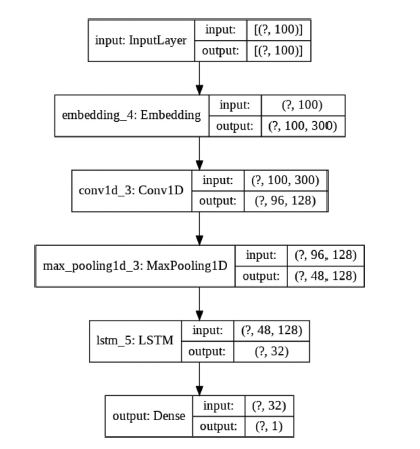

In [6]:
from IPython.display import Image
Image(filename='Model.jpg')

*We used a model that is proposed by Nasir, Khan and Varlamis(2021), we changed only the units of the LSTM from 32->128 So the lstm output & dense layer input is (?,128):*  
[Fake news detection: A hybrid CNN-RNN based deep learning approach](https://reader.elsevier.com/reader/sd/pii/S2667096820300070?token=AA6959D413A71A6F9E40595E6AD8793383EC45D158119218F6929CDE34A7EF3A04EA593E70024059F523EF70E3184ED7&originRegion=eu-west-1&originCreation=20220219184030) 


In [7]:
embedding_vector_features=300
model=Sequential()
model.add(Embedding(vocab,embedding_vector_features,input_length=length))
#output(batch_size, 100, 300)
model.add(Conv1D(128, 5, activation='relu'))
#output(batch_size, 96, 128), (batch_size, (size of input - size of kernel + 1) , number of filters)
model.add(MaxPooling1D(pool_size=1,strides=2,padding='valid'))
#output(batch_size, 48, 128), (batch_size, (size of input - pool_size + 1)/strides, number of filters )
model.add(LSTM(128)) #Adding 128 lstm neurons in the layer
#output(batch_size, 128)
model.add(Dense(1,activation='sigmoid'))
#output(1)
#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Splitting our data and training our model using df_combined

We split df_combined in 33% test data and 67% train data and we train our model with batch size = 64 and epochs = 5. 

In [8]:
X_final=np.array(embedded_docs_combined)
y_final=np.array(df_combined['Fake-Real'])
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [10]:
model.fit(X_train,y_train,epochs=5,batch_size=64, shuffle=True)

Epoch 1/5
101/101 [==============================] - 32s 290ms/step - loss: 0.2875 - accuracy: 0.8874
Epoch 2/5
101/101 [==============================] - 31s 303ms/step - loss: 0.0557 - accuracy: 0.9827
Epoch 3/5
101/101 [==============================] - 31s 303ms/step - loss: 0.0240 - accuracy: 0.9908
Epoch 4/5
101/101 [==============================] - 31s 303ms/step - loss: 0.0179 - accuracy: 0.9924
Epoch 5/5
101/101 [==============================] - 31s 305ms/step - loss: 0.0180 - accuracy: 0.9917


# Saving Weights

Run the following code if you want to save the weights in .txt files and save the weights of the model in a format that they can be loaded.

In [51]:
Embedded_layer_weights = model.layers[0].get_weights()[0]
print("Length of embedded_list:",len(model.layers[0].get_weights()))
print("Shape of Embedded_layer_weights:",Embedded_layer_weights.shape)

Convolution_layer_weights_1 = model.layers[1].get_weights()[0]
Convolution_layer_weights_2 = model.layers[1].get_weights()[1]
print("Length of convolution_list:",len(model.layers[1].get_weights()))
print("Shape of Convolution_layer_weights_1:",Convolution_layer_weights_1.shape)
print("Shape of Convolution_layer_weights_2:",Convolution_layer_weights_2.shape)

print("Length of maxpooling_list:",len(model.layers[2].get_weights()))

Lstm_layer_weights_1 = model.layers[3].get_weights()[0]
Lstm_layer_weights_2 = model.layers[3].get_weights()[1]
Lstm_layer_weights_3 = model.layers[3].get_weights()[2]
print("Length of lstm_list:",len(model.layers[3].get_weights()))
print("Shape of Lstm_layer_weights_1:",Lstm_layer_weights_1.shape)
print("Shape of Lstm_layer_weights_2:",Lstm_layer_weights_2.shape)
print("Shape of Lstm_layer_weights_3:",Lstm_layer_weights_3.shape)

Dense_layer_weights_1 = model.layers[4].get_weights()[0]
Dense_layer_weights_2 = model.layers[4].get_weights()[1]
print("Length of dense_list:",len(model.layers[4].get_weights()))
print("Shape of Dense_layer_weights_1:",Dense_layer_weights_1.shape)
print("Shape of Dense_layer_weights_2:",Dense_layer_weights_2.shape)

with open('Weights\\embedded_weights.txt', 'w') as filehandle:
    for listitem in Embedded_layer_weights:
        filehandle.write('%s\n' % listitem)
        
with open('Weights\\convolution_weights.txt', 'w') as filehandle:
    filehandle.write('Convolution_layer_weights_1\n')
    for listitem1 in Convolution_layer_weights_1[0]:
        for listitem2 in Convolution_layer_weights_1[1]:
            filehandle.write('%s\n' % listitem2)
        
    filehandle.write('Convolution_layer_weights_2\n')
    for listitem in Convolution_layer_weights_2:
        filehandle.write('%s\n' % listitem)
        
with open('Weights\\lstm_weights.txt', 'w') as filehandle:
    filehandle.write('Lstm_layer_weights_1\n')
    for listitem in Lstm_layer_weights_1:
        filehandle.write('%s\n' % listitem)
        
    filehandle.write('Lstm_layer_weights_2\n')
    for listitem in Lstm_layer_weights_2:
        filehandle.write('%s\n' % listitem)
        
    filehandle.write('Lstm_layer_weights_3\n')
    for listitem in Lstm_layer_weights_3:
        filehandle.write('%s\n' % listitem)
        
with open('Weights\\dense_weights.txt', 'w') as filehandle:
    filehandle.write('Dense_layer_weights_1\n')
    for listitem in Dense_layer_weights_1:
        filehandle.write('%s\n' % listitem)
        
    filehandle.write('Dense_layer_weights_2\n')
    for listitem in Dense_layer_weights_2:
        filehandle.write('%s\n' % listitem) 
        
model.save_weights("Weights\\pretrained_weights\\pretrained_weights")        

Length of embedded_list: 1
Shape of Embedded_layer_weights: (20000, 300)
Length of convolution_list: 2
Shape of Convolution_layer_weights_1: (5, 300, 128)
Shape of Convolution_layer_weights_2: (128,)
Length of maxpooling_list: 0
Length of lstm_list: 3
Shape of Lstm_layer_weights_1: (128, 512)
Shape of Lstm_layer_weights_2: (128, 512)
Shape of Lstm_layer_weights_3: (512,)
Length of dense_list: 2
Shape of Dense_layer_weights_1: (128, 1)
Shape of Dense_layer_weights_2: (1,)


Run the following code to load in our sequential model pretrained weights. 

In [50]:
load_status = model.load_weights("Weights\\pretrained_weights\\pretrained_weights")

#  Model evaluation

We evaluate our model using: 
* 33% of the df_combined dataset
* The whole news dataset
* The whole GermanFakeNC  
The metrics used to evaluate our model is a confusion matrix and the F1 score


In [57]:
#predict combined
predicted_combined = model.predict(X_test)
for i in range(0, len(predicted_combined)):
    if predicted_combined[i] > 0.5:
        predicted_combined[i] = 1
    else:
        predicted_combined[i] = 0 

In [58]:
#predict news
X_test_news = np.array(embedded_docs_news)
y_test_news = np.array(df_news['Fake-Real'])
predicted_news = model.predict(X_test_news)
for i in range(0, len(predicted_news)):
    if predicted_news[i] > 0.5:
        predicted_news[i] = 1
    else:
        predicted_news[i] = 0      

In [59]:
#predict GermanFakeNC
X_test_germanFakeNC = np.array(embedded_docs_germanFakeNC)
y_test_germanFakeNC = np.array(df_germanFakeNC['Fake-Real'])
predicted_germanFakeNC = model.predict(X_test_germanFakeNC)
for i in range(0, len(predicted_germanFakeNC)):
    if predicted_germanFakeNC[i] > 0.5:
        predicted_germanFakeNC[i] = 1
    else:
        predicted_germanFakeNC[i] = 0        
        

In [60]:
print("The 67% of df_combined:")
print("Confusion Matrix:\n",confusion_matrix(y_test, predicted_combined))
print("Accuracy:", accuracy_score(y_test, predicted_combined))
print("Precision:", precision_score(y_test, predicted_combined))
print("Recall:", recall_score(y_test, predicted_combined))
print("\nF1-Score",f1_score(y_test, predicted_combined))

print("\nThe news dataset:")
print("Confusion Matrix:\n",confusion_matrix(y_test_news, predicted_news))
print("Accuracy:", accuracy_score(y_test_news, predicted_news))
print("Precision:", precision_score(y_test_news, predicted_news))
print("Recall:", recall_score(y_test_news, predicted_news))
print("\nF1-Score",f1_score(y_test_news, predicted_news))

print("\nThe germanFakeNC dataset:")
print("Confusion Matrix:\n",confusion_matrix(y_test_germanFakeNC, predicted_germanFakeNC))
print("Accuracy:", accuracy_score(y_test_germanFakeNC, predicted_germanFakeNC))
print("Precision:", precision_score(y_test_germanFakeNC, predicted_germanFakeNC))
print("Recall:", recall_score(y_test_germanFakeNC, predicted_germanFakeNC))
print("\nF1-Score",f1_score(y_test_germanFakeNC, predicted_germanFakeNC))


The 67% of df_combined:
Confusion Matrix:
 [[1460  123]
 [  74 1499]]
Accuracy: 0.9375792141951838
Precision: 0.9241676942046856
Recall: 0.9529561347743166

F1-Score 0.9383411580594679

The news dataset:
Confusion Matrix:
 [[4521  106]
 [  65 4562]]
Accuracy: 0.9815215042143938
Precision: 0.9772922022279349
Recall: 0.9859520207477848

F1-Score 0.9816030123722432

The germanFakeNC dataset:
Confusion Matrix:
 [[ 91  41]
 [ 24 152]]
Accuracy: 0.788961038961039
Precision: 0.7875647668393783
Recall: 0.8636363636363636

F1-Score 0.8238482384823848
